# Ordinal analysis of the Color MTurk Experiment (non-centered, ANOVA style)

In [19]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')


from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']


# Data

In [20]:
# Using dtype 'category' for Y
df_color = pd.read_csv(
    'data/color_data_0330.csv',
    dtype={
        'y': 'int',
        'color': 'int',
        'color_position': 'int',
        'cond': 'int'
    })
df_color.rename(columns = {'color_position':'location', 'cond':'framing'}, inplace=True)

In [21]:
# giving an index to each experimental condition
df_color['condition'] = (df_color['location'] + 3*df_color['framing']).astype('category')

In [22]:
(df_color[df_color['condition']==0]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 84 to 118
Data columns (total 5 columns):
color        35 non-null int64
location     35 non-null int64
framing      35 non-null int64
y            35 non-null int64
condition    35 non-null category
dtypes: category(1), int64(4)
memory usage: 1.6 KB


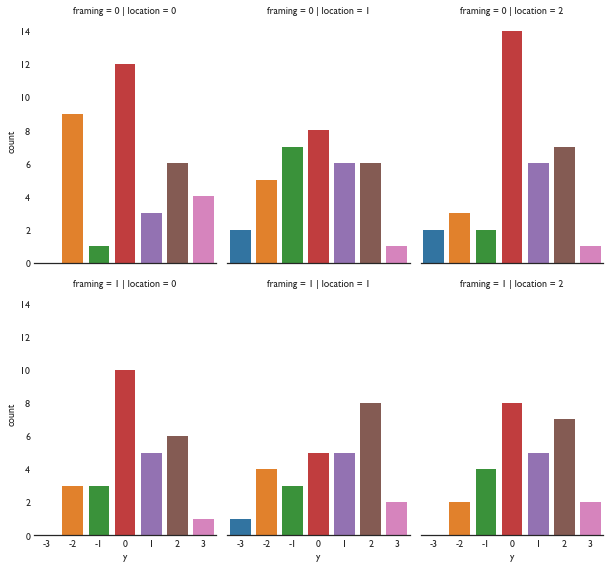

In [23]:
g_color = sb.factorplot(
    x="y",
    col="location",
    row="framing",
    data=df_color,
    kind="count",
    size=4,
    aspect=0.7)
g_color.despine(left=True)
g_color.savefig("factor-responses across conditions.pdf")

In [24]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma

def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [25]:
df_color['color'] = df_color['color'].astype('category')
df_color['framing'] = df_color['framing'].astype('category')
df_color['location'] = df_color['location'].astype('category')

In [26]:
df_color.y.nunique()

7

In [27]:
# levels for the ordinal case

y_cat = (df_color['y']).astype('category')  # in range 1-7 

nYlevels = df_color.y.nunique()
thresh = [k + 0.5
           for k in range(1, nYlevels)]  # fixing the boundaries in our case
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

#initial probabilities
pr_test_val = df_color.groupby('y').size()/df_color.shape[0]
print("Overall Category Probabilities: {}".format(pr_test_val.round(3)))

thresh:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]
Overall Category Probabilities: y
-3    0.026
-2    0.138
-1    0.106
 0    0.302
 1    0.159
 2    0.212
 3    0.058
dtype: float64


In [28]:
# defining the operator to compute the probabilities:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels))
    n = norm(loc=mu, scale=sigma)
    out[:, 0] = n.cdf(theta[0])
    out[:, 1] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:, 2] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:, 3] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:, 4] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:, 5] = np.max(
        [np.repeat(0, mu.size),
         n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:, 6] = 1 - n.cdf(theta[5])
    return out

In [29]:
y = df_color.y
yMean = y.mean()
ySD = y.std()
print("Response (y), Mean: {}, Sigma: {}".format(yMean.round(3), ySD.round(3)))

x1 = df_color.framing.cat.codes.values # array specifying index of 'framing' conditions
Nx1Lvl = len(df_color.framing.cat.categories) # number of frames

x2 = df_color.location.cat.codes.values # array specifying index of 'location' conditions
Nx2Lvl = len(df_color.location.cat.categories) # number of locations

x3 = df_color.color.cat.codes.values # array specifying index of 'color' conditions
Nx3Lvl = len(df_color.color.cat.categories) # number of colors

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)
print("gamma parameters: {}".format(agammaShRa))

Response (y), Mean: 0.296, Sigma: 1.532
gamma parameters: (1.2831955546343297, 0.36963709097698)


In [17]:
Nx3Lvl

2

### with interaction effects

In [18]:
with pm.Model() as ordinal_factor_model_color:

    theta = pm.Normal(
        'theta',
        mu=thresh,
        tau=np.repeat(1 / 2**2, len(thresh)),
        shape=len(thresh),
        observed=thresh_obs,
        testval=thresh)

    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD * 5 * a0_tilde)

    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD * a1_tilde)

    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD * a2_tilde)

    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    #a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD * a1a2_tilde)

    mu = a0 + a1[x1] + a2[x2] + a1a2[x1, x2]
    ySigma = pm.Uniform('ySigma', ySD / 100, ySD * 10)


    pr = outcome_probabilities(theta, mu, ySigma)
    y = pm.Categorical(
        'Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

KeyboardInterrupt: 

### no interaction effects

In [30]:
with pm.Model() as ordinal_factor_model_color:

    theta = pm.Normal(
        'theta',
        mu=thresh,
        tau=np.repeat(1 / 2**2, len(thresh)),
        shape=len(thresh),
        observed=thresh_obs,
        testval=thresh)

    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0',
                          (1 + nYlevels) / 2 + yMean + ySD * 5 * a0_tilde)

    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD * a1_tilde)

    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD * a2_tilde)

    a3SD = pm.Gamma('a3SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a3_tilde = pm.Normal('a3_tilde', mu=0, sd=1, shape=Nx3Lvl)
    a3 = pm.Deterministic('a3', 0.0 + a3SD * a3_tilde)

    mu = a0 + a1[x1] + a2[x2] + a3[x3]
    ySigma = pm.Uniform('ySigma', ySD / 100, ySD * 10)

    pr = outcome_probabilities(theta, mu, ySigma)
    y = pm.Categorical(
        'Y_obs', pr, observed=y_cat.cat.codes, testval=pr_test_val)

In [31]:
with ordinal_factor_model_color:
    step1 = pm.Metropolis()
    trace = pm.sample(50000, chains=8, step=step1)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>Metropolis: [ySigma_interval__]
>Metropolis: [a3_tilde]
>Metropolis: [a3SD_log__]
>Metropolis: [a2_tilde]
>Metropolis: [a2SD_log__]
>Metropolis: [a1_tilde]
>Metropolis: [a1SD_log__]
>Metropolis: [a0_tilde]
>Metropolis: [theta_missing]
100%|██████████| 50500/50500 [2:19:41<00:00,  6.03it/s]
The number of effective samples is smaller than 10% for some parameters.


In [32]:
import pickle #

with open('ordinal_factor_model_color-noint.pkl', 'wb') as buff:
    pickle.dump({'model': ordinal_factor_model_color, 'trace': trace}, buff)
  
# with open('my_model.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# basic_model, trace = data['model'], data['trace']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22cf3b70>,
      dtype=object)

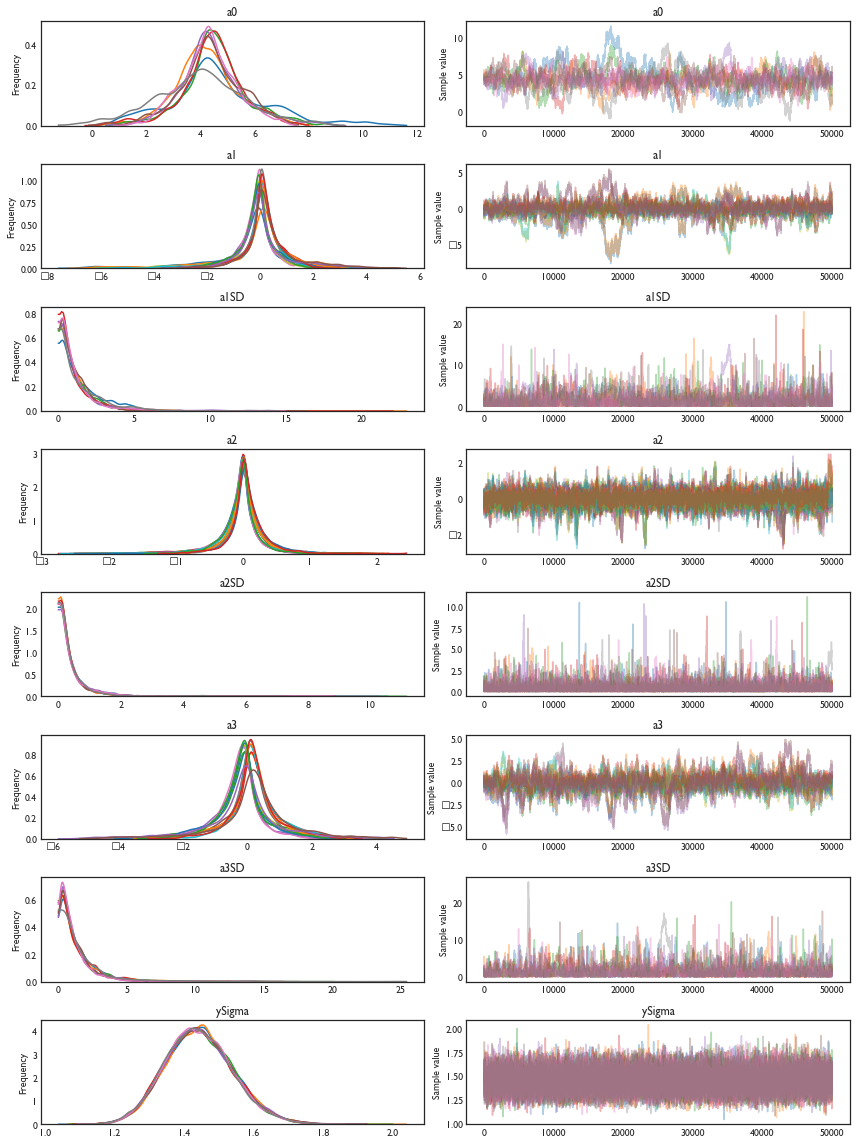

In [33]:
pm.traceplot(trace, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a3', 'a3SD', 'ySigma'])

In [ ]:
tracedf = pm.trace_to_dataframe(trace, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a3', 'a3SD', 'ySigma'])
g = sb.pairplot(tracedf);

KeyboardInterrupt: 

In [1]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl, Nx2Lvl, Nx3Lvl,
              len(trace[a0])))  # notice that this isn't len(trace)
# b1b2 = m.copy()

# interaction effects
# for (j1, j2) in np.ndindex(Nx1Lvl, Nx2Lvl):
#     m[j1, j2] = (trace['a0'] +
#                  trace['a1'][:, j1] +
#                  trace['a2'][:, j2] +
#                  trace['a1a2'][:, j1, j2])

# no interaction effects

for (j1, j2, j3) in np.ndindex(Nx1Lvl, Nx2Lvl, Nx3Lvl):
    m[j1, j2, j3] = (trace['a0'] + trace['a1'][:, j1] 
                     + trace['a2'][:, j2] +
                     trace['a3'][:, j3])

b0 = np.mean(m, axis=(0, 1, 2))
b1 = np.mean(m, axis=(1,2)) - b0
b2 = np.mean(m, axis=(0,2)) - b0
b3 = np.mean(m, axis=(0,1)) - b0
# for (j1, j2) in np.ndindex(Nx1Lvl, Nx2Lvl):
#     b1b2[j1, j2] = (m[j1, j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.mean(b0).round(3)))
print('b1: {}'.format(np.mean(b1, axis=1).round(3)))
print('b2: {}'.format(np.mean(b2, axis=1).round(3)))
print('b3: {}'.format(np.mean(b3, axis=1).round(3)))
# print('b1b2: {}'.format(np.mean(b1b2, axis=2).round(3)))
print('ySigma: {}'.format(np.mean(trace['ySigma']).round(3)))

NameError: name 'np' is not defined

In [ ]:
sigma = trace['ySigma']
nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  # change based on the number of parameters
NCols = 4  # four interior values
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace['theta_missing'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    color='0.75',
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    color='0.75',
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs3[2],
    text_size=10)
pm.plot_posterior(
    trace['theta_missing'][:, 3],
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs3[3],
    round_to=2,
    text_size=10)

# beta_vars = ['intercept', 'color', 'location', 'condition']
for j in range(NCols):
    z = axs3[j]
    #     z.set_xlabel("") # no individual labels
    #     z.set_ylabel("")
    s = "$\\theta_{{{0}}}$".format(j + 2)
    z.set_xlabel("{0}".format(s))
    center = trace['theta_missing'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()

fig3.tight_layout()

fig3.savefig("factors_theta_values_color-no-interaction.pdf")

# mean and mean effect size

fig2, axs2 = sb.mpl.pyplot.subplots(1, 2)  #### change on changing parameters
fig2.set_size_inches(6, 2)

pm.plot_posterior(
    b0,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[0],
    ref_val=4,
    round_to=2,
    text_size=10)
pm.plot_posterior(
    nm,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    ax=axs2[1],
    ref_val=0,
    round_to=2,
    text_size=10)

axs2[0].set_title(r"Mean")
b0m = np.mean(b0)
axs2[0].set_xlim([b0m - 1.5, b0m + 1.5])
axs2[0].set_xlabel(r'$\mu$')

axs2[1].set_title(r"Effect Size")
nmm = np.mean(nm)
axs2[1].set_xlim([nmm - 1.5, nmm + 1.5])
axs2[1].set_xlabel(r'$\frac{\mu-4}{\sigma}$')

axs2[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[0].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[0].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[0].xaxis.set_ticks_position('bottom')
axs2[0].yaxis.set_ticks_position('left')
axs2[0].minorticks_on()

axs2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs2[1].tick_params(
    direction='in', length=6, width=2, colors='k', which='major')
axs2[1].tick_params(
    direction='in', length=4, width=1, colors='k', which='minor')
axs2[1].xaxis.set_ticks_position('bottom')
axs2[1].yaxis.set_ticks_position('left')
axs2[1].minorticks_on()

fig2.tight_layout()
fig2.savefig("factors_mean_effect_color-no-interaction.pdf")

In [ ]:
contrast = b1[1, :] - b1[0, :]

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    contrast,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs,
    ref_val=0,
    text_size=10)

axs.set_title(r"Positive - Negative Framing")
cm = np.mean(contrast)
axs.set_xlim([cm - 1.5, cm + 1.5])
axs.set_xlabel(r'$\beta_{1,1} - \beta_{1,0}$')

axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs.xaxis.set_ticks_position('bottom')
axs.yaxis.set_ticks_position('left')
axs.minorticks_on()
fig.tight_layout()
fig.savefig("factors_framing_contrasts_color-no-interaction.pdf")

In [ ]:
color_contrast = b3[1, :] - b3[0, :]

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    contrast,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs,
    ref_val=0,
    text_size=10)

axs.set_title(r"Color Contrasts")
cm = np.mean(contrast)
axs.set_xlim([cm - 1.5, cm + 1.5])
axs.set_xlabel(r'$\beta_{3,1} - \beta_{3,0}$')

axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs.xaxis.set_ticks_position('bottom')
axs.yaxis.set_ticks_position('left')
axs.minorticks_on()
fig.tight_layout()
fig.savefig("factors_color_contrasts_color-no-interaction.pdf")


In [ ]:
# location contrast
contrast20 = b2[2, :] - b2[0, :] # ground line vs fig
contrast10 = b2[0, :] - b2[1, :] # fig vs text
contrast21 = b2[2, :] - b2[1, :] # ground vs text

fig, axs = sb.mpl.pyplot.subplots(1, 3)  #### change on changing parameters
fig.set_size_inches(9, 2)

pm.plot_posterior(
    contrast10,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs[0],
    ref_val=0,
    text_size=10)


pm.plot_posterior(
    contrast20,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs[1],
    ref_val=0,
    text_size=10)

pm.plot_posterior(
    contrast21,
    point_estimate='mode',
    kde_plot='True',
    color='0.75',
    round_to=2,
    ax=axs[2],
    ref_val=0,
    text_size=10)


axs[0].set_title(r"Color: Figure v. Text")
cm = np.mean(contrast10)
axs[0].set_xlim([cm - 1.5, cm + 1.5])
axs[0].set_xlabel(r'$\beta_{2,1} - \beta_{2,0}$')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[0].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs[0].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs[0].xaxis.set_ticks_position('bottom')
axs[0].yaxis.set_ticks_position('left')
axs[0].minorticks_on()

axs[1].set_title(r"Color: Ground Line v. Figure")
cm = np.mean(contrast20)
axs[1].set_xlim([cm - 1.5, cm + 1.5])
axs[1].set_xlabel(r'$\beta_{2,2} - \beta_{2,0}$')

axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs[1].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs[1].xaxis.set_ticks_position('bottom')
axs[1].yaxis.set_ticks_position('left')
axs[1].minorticks_on()

axs[2].set_title(r"Color: Ground Line v. Text")
cm = np.mean(contrast21)
axs[2].set_xlim([cm - 1.5, cm + 1.5])
axs[2].set_xlabel(r'$\beta_{2,2} - \beta_{2,1}$')

axs[2].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[2].tick_params(direction='in', length=6, width=2, colors='k', which='major')
axs[2].tick_params(direction='in', length=4, width=1, colors='k', which='minor')
axs[2].xaxis.set_ticks_position('bottom')
axs[2].yaxis.set_ticks_position('left')
axs[2].minorticks_on()


fig.tight_layout()
fig.savefig("factors_colorlocation_contrasts_color-noint.pdf")